In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgbm

In [2]:
# Opción para ver todas las columnas del dataset en el notebook
pd.set_option('display.max_columns', 50)

In [3]:
data = "data/bank-additional-full.csv"
df = pd.read_csv(data, sep=";")

In [4]:
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Práctico 04: Aprendizaje Supervisado

Para finalizar nuestro modelo, aplicaremos estrategias de sampling para dividir entre train y test y haremos crossvalidation sobre train. Realizaremos pruebas con varios clasificadores y evaluaremos los resultados con múltiples métricas. Por último calcularemos el feature importance y obtendremos conclusiones.

## Objetivo del práctico

### Train-Validation-Test
(obtener del práctico anterior)
- División del dataset en train/validation/test
- Estratificación

In [5]:
# Reemplazamos la columna y (target) por 1 y 0
df.y = df.y.replace('yes', 1)
df.y = df.y.replace('no', 0)

In [6]:
#Diferenciamos los atributos del target
X = df.drop(columns='y')
y = df.y

In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y)   #Dejamos un conjunto de test con el 20% de los casos 
#Dado que el dataset se encuentra desbalanceado (aprox. 11% del total de casos pertenece a la clase 1), empleamos el parámetro stratified en función del target (y)
#De este modo, la muestra seleccionada a partir de la división sería representativa para las dos clases

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp)

In [9]:
#Para hacer algunas pruebas sin hacer doble division
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, stratify=y)

### Preprocesamiento

- Tratamiento de valores nulos
- Estandarización
- Encoding de variables categóricas

In [10]:
class SelectColumnsTransformer():
    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, **transform_params):
        cpy_df = X[self.columns].copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self

#### Pipeline genérico para pre-procesamiento

In [ ]:
#Aplicamos las transformaciones previas a los conjuntos de Train y Validation

variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]     

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                             ('standard_scaler', StandardScaler())        #Solamente activamos esta línea cuando el clasificador requiere escalado de variables numéricas (SVM, SGD)
                            ])

pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                  ('imputer', SimpleImputer(strategy='most_frequent', missing_values="unknown")),     #Activamos en el caso que quisieramos imputar la categoría desconocido
                                 ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])


train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

### Definición de métricas

Definiremos las métricas a utilizar:
- Accuracy
- Precision
- Recall
- F1
- AUC
- PRAUC  

Además investigaremos como utilizar el classification report y confusion matrix. Adicionalmente, cómo usar crossvalidation.

Dado que el problema se encuetra desbalanceado, la Accuracy no es la medida adecuada para el análisis. Las métricas más adecuadas para el análisis comparativos de los modelos son: Precision, Recall, F1, AUC, PRAUC.

Explicación de las métricas utilizadas a un stakeholder no técnico.

El conjunto de datos con que contamos para el análisis presenta una mayor cantidad de casos pertenecientes al grupo de clientes que no contrataron el PF en la última campaña de marketing en relación a aquellos clientes que si lo contrataron, razón por la cual decimos que el dataset se encuentra desbalanceado. Esta situación implica que contamos con mayor información para caracterizar a quienes no contrarían el PF que aquella disponible para caracterizar al grupo de clientes que si contratarían el PF, es decir, aquellos que constituyen el objetivo para nosotros.

En este caso, para evaluar de manera comparativa una serie de modelos predictivos y poder juzgar cuál/es de ellos son los mejores tenemos que ser cuidadosos al momento de definir las métricas. No es recomendable confiar en métricas que se concentren únicamente en la cantidad de casos que están bien clasificados ya que se le estaría dando una mayor predominancia a las clasificaciones dentro de la clase mayoritaria (clientes que no contratan PF).

En cuanto a las métricas tenemos entonces: 
- La Precisión representa qué porcentaje de los clientes que nuestro modelo predice que van a convertir, efectivamente lo hacen.
- La Recall representa qué porcentaje de los clientes que convierten son captados correctamente por nuestro modelo predicitivo. 

Dado que nos interesa tanto la proporción de clientes que efectivamente convierten así como también la proporción de clientes que convierten bien identificados por el modelo, vamos a optar por una métrica que balancea estas dos cuestiones: la F1. Esta métrica es la media armónica de las dos anteriores, y sirve para poder evaluar comparativamente una serie de modelos contemplando los dos criterios mencionados.    

## Testeo con varios modelos

Realizaremos varios tests con diversos tipos de modelos, tanto aquellos de la librería scikit-learn, como otros que no pertencen a ella:
- Decision Tree
- SGD Classifier
- Logistic regression   (VER ESTE) 
- SVM      (VER ESTE)
- Naive Bayes
- Random Forest
- XGBoost
- LightGBM

Usaremos crossvalidation y compararemos con validation y test.

Realizaremos también optimizaciones de hiperparámetros en busca de los mejores valores para las métricas, empleando tanto Grid Search como Randomizes Search (en los casos en que la búsqueda se vuelva muy compleja).

## **Modelos Analizados**

#### **MODELO BASELINE**

El modelo estimado como baseline para el problema bajo análisis fue un Árbol de Decsisiones, que fue presentado en el Práctico 3 y se incluye abajo para tomar de referencia en la comparación con los nuevos modelos que se entrenarán.

In [13]:
#Pre-procesamiento sobre los conjuntos de Train y Test
variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]


pipeline_numerico = Pipeline([
                             ('select_numeric_columns', SelectColumnsTransformer(variables_numericas))     #Para este modelo no es necesario escalar las variables numéricas
                            ])

pipeline_categorico = Pipeline ([('imputer', SimpleImputer(strategy='most_frequent', missing_values = 'unknown')),
                                   ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])

train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

In [14]:
dt_clf = DecisionTreeClassifier(random_state=0, criterion = 'gini', max_depth = 10, min_samples_leaf = 3, min_samples_split = 2, class_weight="balanced")
dt_clf.fit(train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, random_state=0)

In [16]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= dt_clf.predict(train)
y_val_pred=dt_clf.predict(val)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.96      0.84      0.90     23390
           1       0.36      0.72      0.48      2970

    accuracy                           0.83     26360
   macro avg       0.66      0.78      0.69     26360
weighted avg       0.89      0.83      0.85     26360

VALIDACIÓN
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      5848
           1       0.31      0.58      0.40       742

    accuracy                           0.81      6590
   macro avg       0.62      0.71      0.64      6590
weighted avg       0.87      0.81      0.83      6590



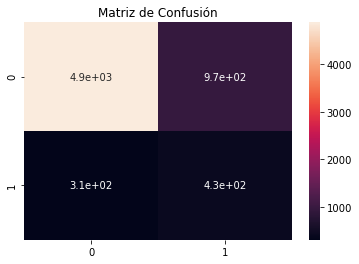

In [20]:
#Generamos la matriz de confusión para interpretar con mayor claridad los resultados
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val,y_val_pred)

sns.heatmap(cm, annot=True)

plt.title("Matriz de Confusión")   
plt.show()

Cabe recordar que el objetivo es maximizar los valores que se encuentran en la diagonal princial (observaciones correctamente clasificadas para cada clase) y minimizar los valores de la diagonal secundaria (errores de clasificación de cada clase). 
En este caso puntual, el objetivo sería minimizar la cantidad de observaciones en el cuadrante inferior izquierdo, que representa clientes que contrataron el PF pero fueron clasificados por el modelo como que no lo contratarían, y el cuadrante superior derecho, que representa clientes que no contrataron el PF pero fueron clasificados por el modelo como que si lo contratarían.

#### **SGDClassifier**

En una primera instancia, entrenamos este modelo a partir de la misma selección de las variables originales, mientras que en una segunda instancia, con el objetivo de mejorar las métricas, se entrenó el modelo a partir de una selección de variables categóricas y las componentes principales que habían sido obtenidas a partir del análisis de componentes principales en el Práctico 2.

In [21]:
#Pre-procesamiento sobre los conjuntos de Train y Validation

variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]     

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                             ('standard_scaler', StandardScaler())      
                            ])

pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                  ('imputer', SimpleImputer(strategy='most_frequent', missing_values="unknown")),
                                 ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])

train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

In [22]:
import warnings
warnings.filterwarnings("ignore")

parameters = {'model__loss':['hinge', 'log','squared_loss'], 'model__learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'], 
              'model__penalty': ['l2', 'l1', 'elasticnet'], 'model__eta0': [ 1e-6,0.001, 0.01, 0.1, 1, 10]}


pipeline = Pipeline([('model',SGDClassifier( random_state= 1))])
sgd_clf = GridSearchCV(pipeline, parameters, scoring=('f1','roc_auc'), cv = 5,return_train_score=True, refit='f1')

sgd_clf.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        SGDClassifier(random_state=1))]),
             param_grid={'model__eta0': [1e-06, 0.001, 0.01, 0.1, 1, 10],
                         'model__learning_rate': ['constant', 'optimal',
                                                  'invscaling', 'adaptive'],
                         'model__loss': ['hinge', 'log', 'squared_loss'],
                         'model__penalty': ['l2', 'l1', 'elasticnet']},
             refit='f1', return_train_score=True, scoring=('f1', 'roc_auc'))

In [23]:
display ('Best configuraton:')
display(sgd_clf.best_params_)
best_sgd_clf = sgd_clf.best_estimator_

'Best configuraton:'

{'model__eta0': 0.1,
 'model__learning_rate': 'constant',
 'model__loss': 'squared_loss',
 'model__penalty': 'l1'}

In [26]:
sgd_clf=SGDClassifier( eta0=0.1, learning_rate='constant', loss='squared_loss', penalty='l1', random_state= 1)
sgd_clf.fit(train, y_train)

SGDClassifier(eta0=0.1, learning_rate='constant', loss='squared_loss',
              penalty='l1', random_state=1)

In [27]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= sgd_clf.predict(train)
y_val_pred=sgd_clf.predict(val)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     23390
           1       0.80      0.00      0.01      2970

    accuracy                           0.89     26360
   macro avg       0.84      0.50      0.47     26360
weighted avg       0.88      0.89      0.84     26360

VALIDACIÓN
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5848
           1       0.50      0.00      0.00       742

    accuracy                           0.89      6590
   macro avg       0.69      0.50      0.47      6590
weighted avg       0.84      0.89      0.83      6590



Como se mencionó anteriormente, se entrenó el modelo con variables categóricas y las variables obtenidas por medio del análisis de componentes principales sobre las variables numéricas. Abajo se incluye el modelo que presentó las mejores métricas.

In [39]:
#Pre-procesamiento sobre los conjuntos de Train y Validation

variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]     

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                             ('standard_scaler', StandardScaler()),
                             ('pca', PCA(n_components=4))
                            ])

pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                  ('imputer', SimpleImputer(strategy='most_frequent', missing_values="unknown")),
                                 ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])

train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

In [40]:
import warnings
warnings.filterwarnings("ignore")

parameters = {'model__loss':['hinge', 'log','squared_loss'], 'model__learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'], 
              'model__penalty': ['l2', 'l1', 'elasticnet'], 'model__eta0': [ 1e-6,0.001, 0.01, 0.1, 1, 10]}


pipeline = Pipeline([('model',SGDClassifier( random_state= 1))])
clf = GridSearchCV(pipeline, parameters, scoring=('f1','roc_auc'), cv = 5,return_train_score=True, refit='f1')

sgd_clf.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        SGDClassifier(random_state=1))]),
             param_grid={'model__eta0': [1e-06, 0.001, 0.01, 0.1, 1, 10],
                         'model__learning_rate': ['constant', 'optimal',
                                                  'invscaling', 'adaptive'],
                         'model__loss': ['hinge', 'log', 'squared_loss'],
                         'model__penalty': ['l2', 'l1', 'elasticnet']},
             refit='f1', return_train_score=True, scoring=('f1', 'roc_auc'))

In [41]:
display ('Best configuraton:')
display(sgd_clf.best_params_)

best_sgd_clf = sgd_clf.best_estimator_


'Best configuraton:'

{'model__eta0': 1,
 'model__learning_rate': 'constant',
 'model__loss': 'log',
 'model__penalty': 'l1'}

In [42]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= best_sgd_clf.predict(train)
y_val_pred=best_sgd_clf.predict(val)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     23390
           1       0.62      0.11      0.19      2970

    accuracy                           0.89     26360
   macro avg       0.76      0.55      0.57     26360
weighted avg       0.87      0.89      0.86     26360

VALIDACIÓN
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      5848
           1       0.63      0.11      0.19       742

    accuracy                           0.89      6590
   macro avg       0.77      0.55      0.57      6590
weighted avg       0.87      0.89      0.86      6590



Las métricas obtenidas a partir del modelo empleando las 4 primeras PCA mejoran, pero sigue sin ofreccer buenos resultados.

#### **Random Forest**

Al igual que en el modelo anterior, entrenamos el modelo en primera instancia con las variables originales y luego probamos contemplando las variables que surgieron del PCA.

In [35]:
#Pre-procesamiento sobre los conjuntos de Train y Validation
variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]

pipeline_numerico = Pipeline([
                             ('select_numeric_columns', SelectColumnsTransformer(variables_numericas))     #Para este modelo no es necesario escalar las variables numéricas
                            ])

pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                 ('imputer', SimpleImputer(strategy='most_frequent', missing_values = None)),
                                   ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])

train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

In [36]:
search_params = {
    'n_estimators': [100, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 6, 10, None],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf':[1,2,3]
}

forest_clf = RandomForestClassifier(random_state=42)
cv_forest_clf = GridSearchCV(forest_clf, search_params, cv=5, scoring='f1', n_jobs=-1)
cv_forest_clf.fit(train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 10, None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 500, 1000]},
             scoring='f1')

In [37]:
display ('Best configuraton:')
display(cv_forest_clf.best_params_)
best_forest_clf = cv_forest_clf.best_estimator_

'Best configuraton:'

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1000}

In [38]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= best_forest_clf.predict(train)
y_val_pred=best_forest_clf.predict(val)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     23390
           1       0.99      0.82      0.90      2970

    accuracy                           0.98     26360
   macro avg       0.98      0.91      0.94     26360
weighted avg       0.98      0.98      0.98     26360

VALIDACIÓN
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5848
           1       0.55      0.25      0.35       742

    accuracy                           0.89      6590
   macro avg       0.73      0.61      0.64      6590
weighted avg       0.87      0.89      0.87      6590



Al igual que en el modelo anterior, entrenamos empleando las 4 primeras componentes que surgen del PCA sobre las variables numéricas y encontramos mejoras en las métricas.

In [55]:
##Pre-procesamiento sobre los conjuntos de Train y Validation
variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]


pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                             ('standard_scaler', StandardScaler()),
                             ('pca', PCA(n_components=4))
                            ])


pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                 ('imputer', SimpleImputer(strategy='most_frequent', missing_values = None)),
                                   ('cat', OneHotEncoder())])


pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])

train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

In [56]:
val.shape

(6590, 39)

In [ ]:
search_params = {
    'n_estimators': [100, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 6, 10, None],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf':[1,2,3]
}

forest_clf = RandomForestClassifier(random_state=42)
cv_forest_clf = GridSearchCV(forest_clf, search_params, cv=5, scoring='f1', n_jobs=-1)
cv_forest_clf.fit(train, y_train)

In [ ]:
display ('Best configuraton:')
display(cv_forest_clf.best_params_)
best_forest_clf = cv_forest_clf.best_estimator_

**Mejores parámetros encontrados para RF**, obtenidos en otra notebook. Los pegamos acá. 

'Best configuraton:'
{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

In [57]:
best_forest_clf=RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=1, min_samples_split=3, n_estimators=100, random_state=42)
best_forest_clf.fit(train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_split=3,
                       random_state=42)

In [58]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= best_forest_clf.predict(train)
y_val_pred=best_forest_clf.predict(val)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     23390
           1       0.97      0.38      0.55      2970

    accuracy                           0.93     26360
   macro avg       0.95      0.69      0.76     26360
weighted avg       0.93      0.93      0.92     26360

VALIDACIÓN
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      5848
           1       0.63      0.18      0.28       742

    accuracy                           0.90      6590
   macro avg       0.77      0.58      0.61      6590
weighted avg       0.87      0.90      0.87      6590



#### **Decision Tree**

Repetimos el entrenamiento del Árbol de decisión a partir de las 4 primeras componentes principales y una selección de las variables categóricas, para chequear si esta opción mejora las métricas.

In [11]:
##Pre-procesamiento sobre los conjuntos de Train y Validation
variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                             ('standard_scaler', StandardScaler()),
                             ('pca', PCA(n_components=4))
                            ])

pipeline_categorico = Pipeline ([('imputer', SimpleImputer(strategy='most_frequent', missing_values = None)),
                                   ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])

train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

In [12]:
import warnings
warnings.filterwarnings("ignore")

parameters = {'criterion':['gini', 'entropy'], 'max_depth':[None, 3, 5, 10, 20, 40], 'min_samples_split': [2,3,4], 'min_samples_leaf':[1,2,3,4]}
tree = DecisionTreeClassifier(random_state=0)

cv_dt_clf = GridSearchCV(tree, parameters, scoring=('f1','roc_auc'), cv = 5,return_train_score=True, refit='f1')

cv_dt_clf.fit(train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 10, 20, 40],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4]},
             refit='f1', return_train_score=True, scoring=('f1', 'roc_auc'))

In [14]:
display ('Best configuraton:')
display(cv_dt_clf.best_params_)
best_dt_clf = cv_dt_clf.best_estimator_

'Best configuraton:'

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

**DT Best Configurationn**, obtenido en otra notebook.

'Best configuraton:'
{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

In [15]:
#No me dio igual a la optimización que había hecho Santi y esta opción óptima overfitea el train
best_dt_clf=DecisionTreeClassifier(criterion='gini', max_depth=20, min_samples_leaf=1, min_samples_split=2,random_state=0)
best_dt_clf.fit(train, y_train)

DecisionTreeClassifier(max_depth=20, random_state=0)

In [16]:
#Predecimos y obtenemos las métricas de este modelo
y_train_pred= best_dt_clf.predict(train)
y_val_pred=best_dt_clf.predict(val)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("VALIDACIÓN")
print(classification_report(y_val, y_val_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     23390
           1       0.96      0.71      0.82      2970

    accuracy                           0.96     26360
   macro avg       0.96      0.85      0.90     26360
weighted avg       0.96      0.96      0.96     26360

VALIDACIÓN
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      5848
           1       0.30      0.31      0.31       742

    accuracy                           0.84      6590
   macro avg       0.61      0.61      0.61      6590
weighted avg       0.84      0.84      0.84      6590



#### **Naive bayes**

In [63]:
variables_categoricas = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
variables_numericas = ['age', 'campaign', 'previous', 'cons.conf.idx', 'euribor3m']

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                             # ('standard_scaler', StandardScaler()),
                             ("kbins_discretizer", KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="uniform")),   #strategy="uniform"
                             ('bins_cat', OneHotEncoder())
                            ])

pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                 #('imputer', SimpleImputer(strategy='most_frequent', missing_values="unknown")),      #podríamos no ponerlo, y que deje "desconocido" como una categoría más
                                 ('cat', OneHotEncoder())
                                 ])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                   ('cat', pipeline_categorico, variables_categoricas),
                                  ])

pipeline_modelo = Pipeline([('preprocess', pipeline_completo),
                            ('nb', ComplementNB())])

#The Complement Naive Bayes classifier was designed to correct the “severe assumptions” made by the standard Multinomial Naive Bayes classifier. It is particularly suited for imbalanced data sets.
#En el pre-procesamiento transformé todos los atributos en categóricos, porque es el requerimiento del tipo de modelo

In [64]:
#Solo Pre-procesamiento
train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.transform(X_v)

In [65]:
#Modelo más sencillo
nb=ComplementNB()
nb.fit(train, y_train)

ComplementNB()

In [66]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, nb.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, nb.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.95      0.75      0.84     23390
           1       0.26      0.68      0.37      2970

    accuracy                           0.74     26360
   macro avg       0.60      0.72      0.61     26360
weighted avg       0.87      0.74      0.79     26360

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      5848
           1       0.25      0.66      0.37       742

    accuracy                           0.74      6590
   macro avg       0.60      0.71      0.60      6590
weighted avg       0.87      0.74      0.78      6590



In [67]:
#Grilla de parámetros para optimización
params={'alpha':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.3, 1.5],
        'fit_prior':[True, False],
        'norm':[True,False]
       }

nb=ComplementNB()

In [68]:
#Búsqueda de los mejores parámetros
cv_nb = GridSearchCV(nb, params, scoring='f1', cv=5,refit=True,n_jobs=-1)     
cv_nb.fit(train, y_train)

GridSearchCV(cv=5, estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1, 1.1, 1.3, 1.5],
                         'fit_prior': [True, False], 'norm': [True, False]},
             scoring='f1')

In [69]:
cv_nb.best_params_

{'alpha': 0.3, 'fit_prior': True, 'norm': True}

In [74]:
#Entrenamiento de la mejor versión encontrada del modelo
nb_best = ComplementNB(alpha=0.3, fit_prior=True, norm=True)
nb_best.fit(train, y_train)

ComplementNB(alpha=0.3, norm=True)

In [75]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, nb_best.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, nb_best.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     23390
           1       0.36      0.46      0.40      2970

    accuracy                           0.85     26360
   macro avg       0.64      0.68      0.66     26360
weighted avg       0.86      0.85      0.85     26360

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      5848
           1       0.36      0.43      0.39       742

    accuracy                           0.85      6590
   macro avg       0.64      0.67      0.65      6590
weighted avg       0.86      0.85      0.85      6590



En la mejor especificación encontrada para este tipo de modelos, y sobre el conjunto de validación, la F1 de la clase minoritaria es 0.39 y la F1 promedio entre las dos clases es 0.65. 

Dentro de la clase minoritaria tenemos que el 36% de los clientes que el modelo indica que contratarían el PF están identificados de manera correcta, y logra capturar al 43% de los clientes que efectivamente contrarían el PF.

#### **XGBoost**

In [76]:
import xgboost as xgb

In [77]:
variables_categoricas = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
variables_numericas = ['age', 'campaign', 'previous', 'cons.conf.idx', 'euribor3m']

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                            ])

pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                 #('imputer', SimpleImputer(strategy='most_frequent', missing_values="unknown")),      #podríamos no ponerlo, y que deje "desconocido" como una categoría más
                                 ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                   ('cat', pipeline_categorico, variables_categoricas),
                                  ])

pipeline_modelo = Pipeline([('preprocess', pipeline_completo),
                            ('xgb', xgb.XGBClassifier(seed=0))])

In [78]:
#Solo Pre-procesamiento
train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.transform(X_v)

In [79]:
xgb=xgb.XGBClassifier(seed=0)
xgb.fit(train, y_train)

[21:03:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [80]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, xgb.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, xgb.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     23390
           1       0.87      0.45      0.60      2970

    accuracy                           0.93     26360
   macro avg       0.90      0.72      0.78     26360
weighted avg       0.93      0.93      0.92     26360

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5848
           1       0.57      0.26      0.36       742

    accuracy                           0.89      6590
   macro avg       0.74      0.62      0.65      6590
weighted avg       0.87      0.89      0.88      6590



In [ ]:
#Optimización de hiperparámetros
#Grilla de parámetros
params={'objective':["binary:logistic","binary:hinge","binary:logitraw"],
        'learning_rate':[ 0.1,0.2,0.3],
        'max_depth':[2,4, 6, 7, 8, 10],
        'alpha':[2, 3, 5, 7],
        "n_estimators":[5, 7, 10]
       }
       
xg=xgb.XGBClassifier()

In [ ]:
#Búsqueda de parámetros
cv_xgb = GridSearchCV(xg, params, scoring='f1', cv=5,refit=True,n_jobs=-1)     
cv_xgb.fit(train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [2, 3, 5, 7],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [2, 4, 6, 7, 8, 10],
             

In [ ]:
cv_xgb.best_params_

{'alpha': 2,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 7,
 'objective': 'binary:hinge'}

In [82]:
import xgboost as xgb

In [83]:
#Entrenamiento de la mejor versión encontrada del modelo en otra notebook
xgb_best = xgb.XGBClassifier(seed=0, alpha= 2, learning_rate= 0.1, max_depth= 7, n_estimators=7, objective='binary:hinge')
xgb_best.fit(train, y_train)

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=7, n_jobs=4, num_parallel_tree=1,
              objective='binary:hinge', random_state=0, reg_alpha=2,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, xgb_best.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, xgb_best.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     23390
           1       0.45      0.56      0.50      2970

    accuracy                           0.87     26360
   macro avg       0.70      0.74      0.72     26360
weighted avg       0.89      0.87      0.88     26360

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      5848
           1       0.44      0.54      0.48       742

    accuracy                           0.87      6590
   macro avg       0.69      0.73      0.71      6590
weighted avg       0.88      0.87      0.88      6590



En este caso, el mejor modelo encontrado sobre el conjunto de validación tiene una F1 igual a 0.48 en la clase minoritaria y una F1 promedio de las dos clases de 0.71.

Dentro de la clase minoritaria tenemos que el 44% de los clientes que el modelo indica que contratarían el PF están identificados de manera correcta, y logra capturar al 54% de los clientes que efectivamente contrarían el PF.

In [85]:
#Probamos con una variedad de combinaciones de variables, para validar cuáles son las más apropiadas para el modelo.
#La mejor combinación de variables fue esta:
variables_categoricas = ['job', 'education', 'contact','loan', 'day_of_week', 'poutcome']
variables_numericas = ['age', 'campaign','previous', 'cons.conf.idx', 'euribor3m']

In [88]:
# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                            ])

pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                 #('imputer', SimpleImputer(strategy='most_frequent', missing_values="unknown")),      #podríamos no ponerlo, y que deje "desconocido" como una categoría más
                                 ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                   ('cat', pipeline_categorico, variables_categoricas),
                                  ])


In [89]:
#Solo Pre-procesamiento
train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.transform(X_v)

In [90]:
#Optimización de hiperparámetros
#Grilla de parámetros
params={'objective':["binary:logistic","binary:hinge","binary:logitraw"],
        'learning_rate':[ 0.1,0.2,0.3],
        'max_depth':[2,4, 6, 7, 8, 10],
        'alpha':[2, 3, 5, 7],
        "n_estimators":[5, 7, 10]
       }
       
xg=xgb.XGBClassifier()

In [91]:
#Búsqueda de parámetros
cv_xgb = GridSearchCV(xg, params, scoring='f1', cv=5,refit=True,n_jobs=-1)     
cv_xgb.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [92]:
cv_xgb.best_params_

{'alpha': 2,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 7,
 'objective': 'binary:hinge'}

In [93]:
#Entrenamiento de la mejor versión encontrada del modelo en otra notebook
xgb_best = xgb.XGBClassifier(seed=0, alpha= 2, learning_rate= 0.1, max_depth= 10, n_estimators=7, objective='binary:hinge')
xgb_best.fit(train, y_train)

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=7, n_jobs=4, num_parallel_tree=1,
              objective='binary:hinge', random_state=0, reg_alpha=2,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [94]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, xgb_best.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, xgb_best.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     23390
           1       0.45      0.59      0.51      2970

    accuracy                           0.87     26360
   macro avg       0.70      0.75      0.72     26360
weighted avg       0.89      0.87      0.88     26360

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      5848
           1       0.42      0.56      0.48       742

    accuracy                           0.86      6590
   macro avg       0.68      0.73      0.70      6590
weighted avg       0.88      0.86      0.87      6590



Alternativamente, probamos con optimizaciones aleatorias de parámetros y ofrecer mayor variabilidad a los parámetros.

In [95]:
#Optimización de hiperparámetros
#Grilla de parámetros
params={'objective':["binary:logistic","binary:hinge","binary:logitraw"],
        'learning_rate':[0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5],
        'max_depth':[2,3, 4,5, 6, 7, 8, 9, 10, 12, 15],
        'alpha':[0, 0.5, 1, 2, 3, 5],
        'lambda':[0.5, 1, 2, 3, 5],
        "n_estimators":[3, 5, 6, 7, 8, 9, 10, 15],
        "booster":["gbtree","dart"],
        "gamma":[0.5,1,2,5, 7, 8],
        "tree_method":["auto","exact","approx","hist"]
       }
xg=xgb.XGBClassifier()

In [96]:
#Búsqueda de parámetros
rcv_xgb = RandomizedSearchCV(xg, params, scoring='f1', cv=5,refit=True,n_jobs=-1)     
rcv_xgb.fit(train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                   param_distributions={'alpha': [0, 0.5, 1, 2, 3, 5],
                                        'booster': ['gbtree', 'dart'],
                                       

In [97]:
rcv_xgb.best_params_

{'tree_method': 'hist',
 'objective': 'binary:hinge',
 'n_estimators': 15,
 'max_depth': 7,
 'learning_rate': 0.05,
 'lambda': 5,
 'gamma': 0.5,
 'booster': 'dart',
 'alpha': 0}

In [98]:
#Entrenamiento de la mejor versión encontrada del modelo
xgb_best_r = xgb.XGBClassifier(seed=0, alpha= 0, booster="dart", gamma= 0.5, reg_lambda=5, learning_rate= 0.05, 
                               max_depth= 7,n_estimators=15, objective="binary:hinge", tree_method= 'hist'   
                                )   #el lambda por default es 1
xgb_best_r.fit(train, y_train)

XGBClassifier(alpha=0, base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=15, n_jobs=4, num_parallel_tree=1,
              objective='binary:hinge', random_state=0, reg_alpha=0,
              reg_lambda=5, scale_pos_weight=None, seed=0, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

In [99]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, xgb_best_r.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, xgb_best_r.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     23390
           1       0.46      0.56      0.51      2970

    accuracy                           0.88     26360
   macro avg       0.70      0.74      0.72     26360
weighted avg       0.89      0.88      0.88     26360

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      5848
           1       0.44      0.53      0.48       742

    accuracy                           0.87      6590
   macro avg       0.69      0.72      0.70      6590
weighted avg       0.88      0.87      0.88      6590



Probamos alternativamente con las primeras 4 componentes principales del PCA sobre las variables numéricas:

In [114]:
##Pre-procesamiento sobre los conjuntos de Train y Validation
variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                             ('standard_scaler', StandardScaler()),
                             ('pca', PCA(n_components=4))
                            ])

pipeline_categorico = Pipeline ([('imputer', SimpleImputer(strategy='most_frequent', missing_values = None)),
                                   ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])

train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

In [115]:
#Optimización de hiperparámetros
#Grilla de parámetros
params={'objective':["binary:logistic","binary:hinge","binary:logitraw"],
        'learning_rate':[ 0.1,0.2,0.3],
        'max_depth':[2,4, 6, 7, 8, 10],
        'alpha':[2, 3, 5, 7],
        "n_estimators":[5, 7, 10]
       }
       
xg=xgb.XGBClassifier()

In [116]:
#Búsqueda de parámetros
cv_xgb = GridSearchCV(xg, params, scoring='f1', cv=5,refit=True,n_jobs=-1)     
cv_xgb.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [117]:
cv_xgb.best_params_

{'alpha': 5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 7,
 'objective': 'binary:hinge'}

In [118]:
#Entrenamiento de la mejor versión encontrada del modelo
xgb_best= xgb.XGBClassifier(seed=0, alpha= 5, learning_rate= 1, 
                               max_depth= 10,n_estimators=7, objective="binary:hinge"   
                                )   #el lambda por default es 1
xgb_best.fit(train, y_train)

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=7, n_jobs=4, num_parallel_tree=1,
              objective='binary:hinge', random_state=0, reg_alpha=5,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [119]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, xgb_best.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, xgb_best.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     23390
           1       0.85      0.43      0.57      2970

    accuracy                           0.93     26360
   macro avg       0.89      0.71      0.77     26360
weighted avg       0.92      0.93      0.92     26360

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5848
           1       0.51      0.30      0.38       742

    accuracy                           0.89      6590
   macro avg       0.71      0.63      0.66      6590
weighted avg       0.87      0.89      0.88      6590



##NO PUDE REPLICAR ESTE RESULTADO

Comentario:

El mejor modelo encontrado usando como variables prpedictoras las 4 PCA, me da lo siguiente: 

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     22472
           1       0.57      0.72      0.63      2587
    accuracy                           0.91     25059
   macro avg       0.77      0.83      0.79     25059
weighted avg       0.93      0.91      0.92     25059

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      5618
           1       0.51      0.65      0.58       647
    accuracy                           0.90      6265
   macro avg       0.74      0.79      0.76      6265
weighted avg       0.91      0.90      0.91      6265

#### **LGMB**

In [120]:
import lightgbm as lgb 

In [121]:
variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]     

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                             ('standard_scaler', StandardScaler())      
                            ])

pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                  ('imputer', SimpleImputer(strategy='most_frequent', missing_values="unknown")),
                                 ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])


train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

In [122]:
lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(train, y_train)

LGBMClassifier()

In [123]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, lgb_clf.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, lgb_clf.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     23390
           1       0.77      0.33      0.46      2970

    accuracy                           0.91     26360
   macro avg       0.84      0.66      0.71     26360
weighted avg       0.90      0.91      0.90     26360

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5848
           1       0.60      0.28      0.38       742

    accuracy                           0.90      6590
   macro avg       0.76      0.63      0.66      6590
weighted avg       0.88      0.90      0.88      6590



**EXPLORAR UN POCO MÁS ESTE MODELO**

In [124]:
clf2 = lgb.LGBMClassifier(class_weight={0: 10, 
                1: 1})
clf2.fit(train, y_train)

LGBMClassifier(class_weight={0: 10, 1: 1})

In [125]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, clf2.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, clf2.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     23390
           1       1.00      0.08      0.15      2970

    accuracy                           0.90     26360
   macro avg       0.95      0.54      0.55     26360
weighted avg       0.91      0.90      0.86     26360

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5848
           1       0.78      0.05      0.10       742

    accuracy                           0.89      6590
   macro avg       0.84      0.53      0.52      6590
weighted avg       0.88      0.89      0.85      6590



Probamos el entrenamiento de este modelo usando las 4 primeras componentes principales y las variables categóricas para ver si mejoran las métricas.

In [126]:
##Pre-procesamiento sobre los conjuntos de Train y Validation
variables_categoricas = ['job', 'marital','education','housing', 'loan','contact','poutcome']
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx' ]

# Filtramos las variables que seleccionamos
X_t = X_train[variables_categoricas + variables_numericas]
X_v = X_val[variables_categoricas + variables_numericas]

pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_numericas)),
                             ('standard_scaler', StandardScaler()),
                             ('pca', PCA(n_components=4))
                            ])

pipeline_categorico = Pipeline ([('imputer', SimpleImputer(strategy='most_frequent', missing_values = None)),
                                   ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_numericas),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])

train = pipeline_completo.fit_transform(X_t)
val = pipeline_completo.fit_transform(X_v)

In [127]:
lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(train, y_train)

LGBMClassifier()

In [128]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train, lgb_clf.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, lgb_clf.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     23390
           1       0.80      0.33      0.47      2970

    accuracy                           0.92     26360
   macro avg       0.86      0.66      0.71     26360
weighted avg       0.91      0.92      0.90     26360

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5848
           1       0.61      0.23      0.34       742

    accuracy                           0.90      6590
   macro avg       0.76      0.61      0.64      6590
weighted avg       0.88      0.90      0.88      6590



### Feature importance y explainability

#### Decision Tree

In [ ]:
best_dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        min_samples_leaf=3, random_state=0)

In [ ]:
#Corremos el pipeline con los parámetros del mejor modelo econtrado:

pipeline_modelo_dt = Pipeline([('preprocess', pipeline_completo),
                            ('rf', best_dt_clf)])
pipeline_modelo_dt.fit(X_t, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('select_numeric_columns',
                                                                   <__main__.SelectColumnsTransformer object at 0x7f0d5a656790>),
                                                                  ('standard_scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True)),
                                   

#### Obtener los nombres de las variables

In [ ]:
# Si realizamos one hot encoding, vamos a tener el problema de que se incrementan el numero de features y necesitamos la nueva lista.
numeric_features = variables_pca
cat_features = pipeline_modelo_dt.named_steps['preprocess'].transformers_[1][1][1].get_feature_names(variables_categoricas)

In [ ]:
onehot_columns = np.array(cat_features)
numeric_features_list = np.array(numeric_features)
numeric_features_list = np.append(numeric_features_list, onehot_columns)

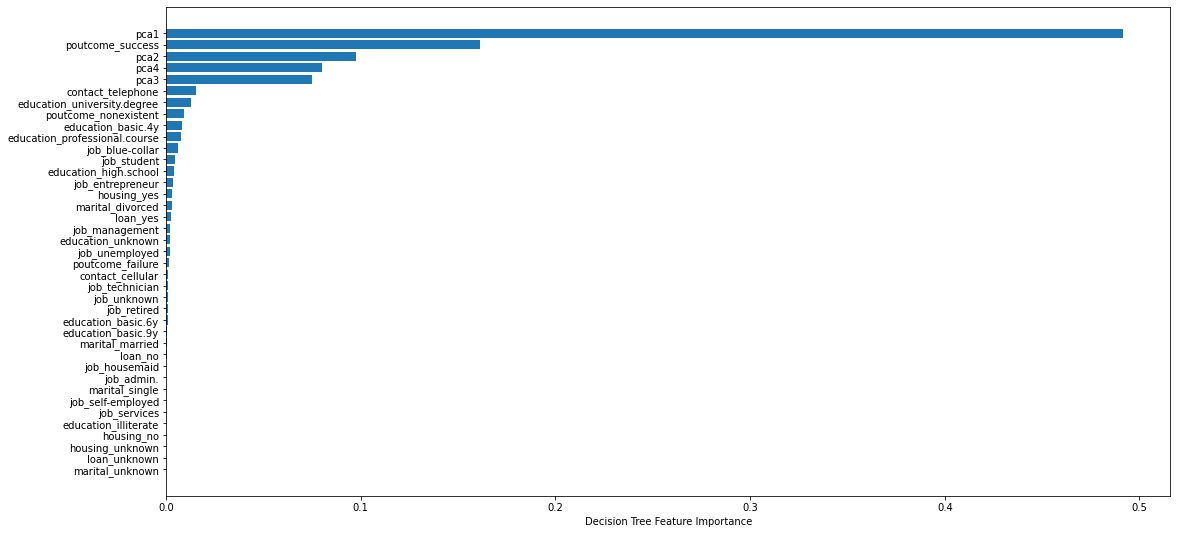

In [ ]:
# Es necesario ordenar las los valores del feature importance (utilizamos argsort para tener el orden de los indices)
sorted_idx = pipeline_modelo_dt[1].feature_importances_.argsort()
plt.figure(figsize = (18,9))
plt.barh(numeric_features_list[sorted_idx], pipeline_modelo_dt[1].feature_importances_[sorted_idx])
plt.xlabel("Decision Tree Feature Importance")
plt.show()

#### Graficar las variables originales que tuvieron más peso en el PCA

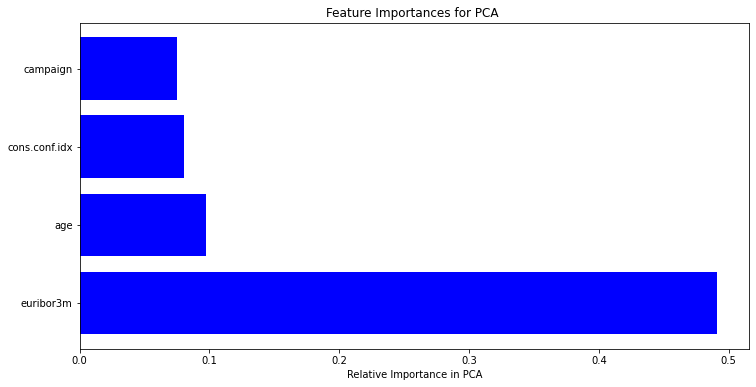

In [ ]:
pca = pipeline_completo.transformers_[0][1][2]

n_pcs= pca.components_.shape[0]
initial_feature_names = X_t[variables_numericas].columns
most_important = [np.abs(pca.components_[i]).argmax() for i in     range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
zipped_feats = zip(most_important_names, pipeline_modelo_dt[1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features, importances = zip(*zipped_feats)
top_features = features[:5]
top_importances = importances[:5]
plt.figure(figsize=(12,6))
plt.title('Feature Importances for PCA ')
plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel('Relative Importance in PCA')
plt.show()

In [ ]:
most_important

[3, 0, 1, 4]